In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

### Case Data

In [10]:
df = pd.read_csv('./all_data_detail_v3.csv')
df.head(3)

,Unnamed: 0,Case,裝潢費用:,居住成員:,設計風格:,房屋類型:,房屋坪數:,房屋狀況:,圖片提供:,空間格局:,主要建材:,pic_num
0,0,14000,101萬～200萬,大人×2,混搭風,標準格局,33.0,新成屋,崢嶸設計有限公司,2房、2廳、2衛、書房、更衣間,義大利薄磚、鋼刷木皮、鐵件金屬、手刮木地板、硅藻土、文化石、特殊壁布,1
1,1,14001,68萬（全室裝修、系統櫃）,大人×2,NaN,小坪數,18.0,老屋翻新,GAGU統包工程,2房、2廳,超耐磨木地板、樂土牆、F3系統櫃板材,1
2,2,14002,尚未提供,大人×3,美式風,標準格局,NaN,老屋翻新,摩登雅舍室內裝修設計有限公司,NaN,壁布、鏡面、磁性烤漆玻璃、止滑地磚、花磚、線板,1


In [11]:
new_columns = [col.replace(':', '') for col in df.columns]
df.columns = new_columns
df = df[['Case', '裝潢費用', '設計風格', '房屋類型', '房屋坪數', '房屋狀況', '空間格局']]

In [16]:
df['裝潢費用'] = df['裝潢費用'].str.replace("`", "")
df['裝潢費用'] = df['裝潢費用'].str.replace(r'\(.*', '', regex=True)
df['裝潢費用'] = df['裝潢費用'].str.replace(r'（.*', '', regex=True)
df['裝潢費用'] = df['裝潢費用'].str.replace(r'[~～]', '-', regex=True)
df['裝潢費用'] = df['裝潢費用'].str.replace('萬', '', regex=True)
df['裝潢費用'] = df['裝潢費用'].str.replace('k', '', regex=True)

def process_range(row):
    if '-' in row:
        a, b = map(float, row.split('-'))
        c = (a + b) / 2
        return str(c)
    elif '以下' in row:
        a = float(row.replace('以下', '').strip())
        return str(a / 2)
    else:
        return row

df['裝潢費用'] = df['裝潢費用'].apply(process_range)

df = df[~df['裝潢費用'].isin(['尚未提供'])]
df = df[~df['裝潢費用'].str.contains('以上')]

df['裝潢費用'] = df['裝潢費用'].astype(float)

In [17]:
pattern = r'(\d+)房、(\d+)廳、(\d+)衛'
df[['空間格局_房', '空間格局_廳', '空間格局_衛']] = df['空間格局'].str.extract(pattern)
df = df.dropna()
df[['空間格局_房', '空間格局_廳', '空間格局_衛']] = df[['空間格局_房', '空間格局_廳', '空間格局_衛']].astype(int)
df = df.drop(columns=['空間格局'], axis=1)

In [18]:
df = pd.get_dummies(df, columns=['設計風格', '房屋類型', '房屋狀況'])

In [79]:
Q1 = df['裝潢費用'].quantile(0.25)
Q3 = df['裝潢費用'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['裝潢費用'] < (Q1 - 1.5 * IQR)) | (df['裝潢費用'] > (Q3 + 1.5 * IQR)))]

In [19]:
df.head()

,Case,裝潢費用,房屋坪數,空間格局_房,空間格局_廳,空間格局_衛,設計風格_休閒多元,設計風格_其他,設計風格_前衛風,設計風格_北歐風,...,房屋類型_挑高樓層,房屋類型_樓中樓,房屋類型_標準格局,房屋類型_民宿旅館,房屋狀況_不限,房屋狀況_中古屋,房屋狀況_新成屋,房屋狀況_毛胚屋,房屋狀況_老屋翻新,房屋狀況_自地自建
0,14000,150.5,33.0,2,2,2,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
5,14005,450.0,70.0,4,2,4,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,14008,150.5,34.0,3,2,2,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
11,14011,75.0,22.0,2,2,2,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
12,14012,100.0,30.0,3,2,2,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [119]:
len(df)

870

### Image Feature

In [62]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.decomposition import PCA
import tensorflow as tf

In [67]:
def extract_image_features(folder_path):
    min_image_number = float('inf')
    min_image_path = None

    # 找到資料夾中數字最小的圖片檔 (首圖)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.jpg'):
            image_number = int(os.path.splitext(file_name)[0])
            if image_number < min_image_number:
                min_image_number = image_number
                min_image_path = os.path.join(folder_path, file_name)

    if min_image_path:
        img = image.load_img(min_image_path, target_size=(256,256))
        img = image.img_to_array(img)
        
        # 將圖片縮放到256x256
        img = tf.image.resize(img, [256, 256])

        # 裁剪中間的224x224部分
        img = tf.image.central_crop(img, central_fraction=224/256)

        # 確保圖片大小為224x224
        img = tf.image.resize(img, [224, 224])

        # 將圖片轉換為數組並進行預處理
        img = np.array(img) 
        img.setflags(write=1) 

        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        vgg_model = VGG16(weights='imagenet', include_top=False)  # 使用VGG16模型去掉頂層
        img_features = vgg_model.predict(img)
        return img_features.flatten()
    else:
        return None

In [68]:
# 對房屋基本資訊dataframe中的每個Case欄代表的圖片進行處理
img_features_list = []
for case in df['Case']:
    folder_path = os.path.join("D:\碩一\Deep learning\Project\img2-20240525T104825Z-001\img2\\", str(case))  # 資料夾路徑
    img_features = extract_image_features(folder_path)
    if img_features is not None:
        img_features_list.append(img_features)

# 將特徵轉換成numpy array
img_features_array = np.array(img_features_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [70]:
# 使用PCA降維成100維
pca = PCA(n_components=350)
img_features_pca = pca.fit_transform(img_features_array)

# 輸出保留的變異量
total_variance_retained = np.sum(pca.explained_variance_ratio_)
print("保留了 {:.2%} 的變異".format(total_variance_retained))

保留了 71.34% 的變異


In [71]:
# 將降維後的特徵合併至原始的房屋基本資訊dataframe
df['img feature'] = img_features_pca.tolist()
df.head(3)

,Case,裝潢費用,房屋坪數,空間格局_房,空間格局_廳,空間格局_衛,設計風格_休閒多元,設計風格_其他,設計風格_前衛風,設計風格_北歐風,...,房屋類型_樓中樓,房屋類型_標準格局,房屋類型_民宿旅館,房屋狀況_不限,房屋狀況_中古屋,房屋狀況_新成屋,房屋狀況_毛胚屋,房屋狀況_老屋翻新,房屋狀況_自地自建,img feature
0,14000,150.5,33.0,2,2,2,0,0,0,0,...,0,1,0,0,0,1,0,0,0,"[-13.613170623779297, 55.70576858520508, -110...."
5,14005,450.0,70.0,4,2,4,0,0,0,0,...,0,0,0,0,0,0,0,1,0,"[-126.06245422363281, -141.0867156982422, 306...."
8,14008,150.5,34.0,3,2,2,0,0,0,0,...,0,1,0,0,0,1,0,0,0,"[216.8434295654297, 333.18231201171875, 244.49..."


### Model

In [81]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, Attention, Flatten, MultiHeadAttention, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 提取特徵和標籤
X_image = np.array(df['img feature'].tolist())
X_info = df.drop(columns=['Case', '裝潢費用', 'img feature'])
y = df['裝潢費用'].values

# 標準化數值特徵
scaler = StandardScaler()
X_info_scaled = scaler.fit_transform(X_info)

# 切分訓練集和測試集
X_info_train, X_info_test, X_image_train, X_image_test, y_train, y_test = train_test_split(X_info_scaled, X_image, y, test_size=0.2, random_state=42)

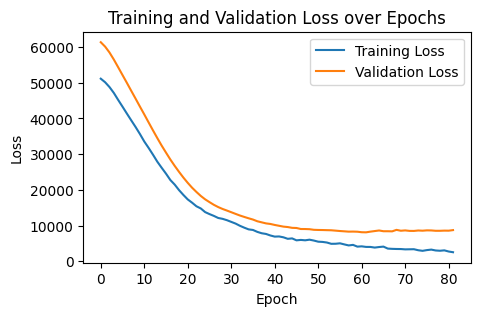

Test Loss: 8920.75


In [135]:
# 設計 MLP 模型
info_input = Input(shape=(X_info_train.shape[1],))
image_input = Input(shape=(X_image_train.shape[1],))

# 定義房屋資訊分支
x_info = Dense(64, activation='tanh')(info_input)
x_info = Dropout(0.3)(x_info) 
x_info = Dense(32, activation='relu')(x_info)

# 定義圖片特徵分支
x_image = Dense(128, activation='tanh')(image_input)
x_image = Dropout(0.3)(x_image) 
x_image = Dense(64, activation='relu')(x_image)

# 合併兩個分支
x = Concatenate()([x_info, x_image])
x = Dense(64, activation='tanh')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1)(x)

# 定義和編譯模型
model_mlp = Model(inputs=[info_input, image_input], outputs=output)
model_mlp.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# 定義 EarlyStopping
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)

# 訓練模型，保存每個 epoch 的訓練和驗證損失
history = model_mlp.fit([X_info_train, X_image_train], y_train, 
                    epochs=300, 
                    batch_size=32, 
                    validation_split=0.2,
                    callbacks=[early_stopping], 
                    verbose=0)

# 繪製訓練損失和驗證損失曲線
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# 在測試集上評估模型
test_loss = model_mlp.evaluate([X_info_test, X_image_test], y_test, verbose=0)
print(f"Test Loss: {round(test_loss, 2)}")

In [120]:
model_mlp.summary()

Model: "functional_107"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1922    │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1923    │ (None, 350)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_374 (Dense)   │ (None, 64)        │      2,560 │ input_layer_1922… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_376 (Dense)   │ (None, 128)       │     44,928 │ input_layer_1923… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_164         │ (None, 64)        │          0 │ dense_374[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_165         │ (None, 128)       │          0 │ dense_376[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_375 (Dense)   │ (None, 32)        │      2,080 │ dropout_164[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_377 (Dense)   │ (None, 64)        │      8,256 │ dropout_165[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_53      │ (None, 96)        │          0 │ dense_375[0][0],  │
│ (Concatenate)       │                   │            │ dense_377[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_378 (Dense)   │ (None, 64)        │      6,208 │ concatenate_53[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_166         │ (None, 64)        │          0 │ dense_378[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_379 (Dense)   │ (None, 32)        │      2,080 │ dropout_166[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_380 (Dense)   │ (None, 1)         │         33 │ dense_379[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 198,437 (775.15 KB)

 Trainable params: 66,145 (258.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 132,292 (516.77 KB)

In [90]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# 合併訓練資料的圖片特徵和房屋資訊
X_train = np.concatenate((X_info_train, X_image_train), axis=1)

# 合併測試資料的圖片特徵和房屋資訊
X_test = np.concatenate((X_info_test, X_image_test), axis=1)

xgb_model = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [3, 4, 5] 
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_xgb_model = XGBRegressor(**best_params, random_state=42)

best_xgb_model.fit(X_train, y_train)

y_pred_best_xgb = best_xgb_model.predict(X_test)

mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
print("XGBoost MSE:", round(mse_best_xgb, 2))

Best parameters: {'max_depth': 4, 'n_estimators': 200}
XGBoost MSE: 9378.3
